In [1]:
import numpy as np
import matplotlib.pyplot as pl
#%matplotlib qt5
from tool._fixedInt import *

In [2]:
def rcosine(beta, Tbaud, oversampling, Nbauds, Norm):
    """ Respuesta al impulso del pulso de caida cosenoidal """
    t_vect = np.arange(-0.5*Nbauds*Tbaud, 0.5*Nbauds*Tbaud, 
                       float(Tbaud)/oversampling) #limitacion de la respuesta al impulso

    y_vect = [] 
    #generacion del conseno realsado
    for t in t_vect:
        y_vect.append(np.sinc(t/Tbaud)*(np.cos(np.pi*beta*t/Tbaud)/    
                                        (1-(4.0*beta*beta*t*t/
                                            (Tbaud*Tbaud)))))

    y_vect = np.array(y_vect)

    if(Norm):
        return (t_vect, y_vect/np.sqrt(np.sum(y_vect**2)))
        #return (t_vect, y_vect/y_vect.sum())
    else:
        return (t_vect,y_vect)

In [3]:
#generacion de respuesta en frecuencia
def resp_freq(filt, Ts, Nfreqs):
    """Computo de la respuesta en frecuencia de cualquier filtro FIR"""
    H = [] # Lista de salida de la magnitud
    A = [] # Lista de salida de la fase
    filt_len = len(filt)

    #### Genero el vector de frecuencias
    freqs = np.matrix(np.linspace(0,1.0/(2.0*Ts),Nfreqs))
    #### Calculo cuantas muestras necesito para 20 ciclo de
    #### la mas baja frec diferente de cero
    Lseq = 20.0/(freqs[0,1]*Ts)

    #### Genero el vector tiempo
    t = np.matrix(np.arange(0,Lseq))*Ts

    #### Genero la matriz de 2pifTn
    Omega = 2.0j*np.pi*(t.transpose()*freqs)

    #### Valuacion de la exponencial compleja en todo el
    #### rango de frecuencias
    fin = np.exp(Omega)

    #### Suma de convolucion con cada una de las exponenciales complejas
    for i in range(0,np.size(fin,1)):
        fout = np.convolve(np.squeeze(np.array(fin[:,i].transpose())),filt)
        mfout = abs(fout[filt_len:len(fout)-filt_len])
        afout = np.angle(fout[filt_len:len(fout)-filt_len])
        H.append(mfout.sum()/len(mfout))
        A.append(afout.sum()/len(afout))

    return [H,A,list(np.squeeze(np.array(freqs)))]

In [4]:
def eyediagram(data, n, offset, period):
    span     = 2*n
    segments = int(len(data)/span)
    xmax     = (n-1)*period
    xmin     = -(n-1)*period
    x        = list(np.arange(-n,n,)*period)
    xoff     = offset

    pl.figure()
    for i in range(0,segments-1):
        pl.plot(x, data[(i*span+xoff):((i+1)*span+xoff)],'b')       
    pl.grid(True)
    pl.xlim(xmin, xmax)
    pl.show()

In [5]:
#filtro fir sin nunguna optimizacion
def fir1(x,h):
    r = np.zeros(len(h)-1) #registro
    y = np.zeros(len(x))   #salida
    for i in range(len(x)):
        y[i] = x[i] * h[i-i]       #multiplicacion el simbolo de entrada con h[0]
        for e in range(len(h)-1):
            y[i] += r[e] * h[e+1]  #voy multiplicando guardados en el registro
        r = np.roll(r,1)           #desplazo el simbolo dentro del registro
        r[0] = x[i]                #guardo el ultimo simbolo que ingreso
    return y

In [6]:
##   filtro fir polifasico
#decompongo el filtro en base a ov, si ov = 4 ==> 4 fases (4 subfiltros)
#por cada simbolo tengo os(4) salidas dada por los sub filtros, por lo que la salida es una convinacion de estas 
def fir_polifasico(symbols,os):
    y_poli=np.zeros(len(symbols)*int(os))
    for i in range(int(os)):   
        h_sub = h[i::int(os)]       #obtengo los coeficientes para cada sub filtro 
        y_aux = fir1(symbols,h_sub) #obtengo las salidas por cada filtro
        y_poli[i::int(os)]=y_aux    #convino las salidad de los filtros para generar la salidad real
    return y_poli
#recordatorio: en verilog se pueden multiplexar los coeficientes por medio de un contador de 2bit a la frecuencia del SR para los distinto coeficientes

In [7]:
def fir_polifasico1(symbols,h):
    h0=h[0::int(os)]
    h1=h[1::int(os)]
    h2=h[2::int(os)]
    h3=h[3::int(os)]
    r=np.zeros(len(h0)-1)
    y=[]
    x=symbols
    for i in range(0,len(x)):
        for e in range(int(os)):
            if(e==0):
                y.append(x[i]*h0[0]+np.dot(r,h0[1:]))
            if(e==1):
                y.append(x[i]*h1[0]+np.dot(r,h1[1:]))
            if(e==2):
                y.append(x[i]*h2[0]+np.dot(r,h2[1:]))
            if(e==3):
                y.append(x[i]*h3[0]+np.dot(r,h3[1:]))
        r=np.roll(r,1)
        r[0]=x[i]
    return y

In [8]:
## Parametros generales
Baud  = 1.0e9           # baudrate 
T     = (1.0/Baud)     # Periodo de baudio
Nsymb = 100             # Numero de simbolos
os    = 4               # Factor de sobre muestreo(oversampling), cantidad de muestras por periodo para representar el coseno 

## Parametros de la respuesta en frecuencia
Nfreqs = 256            # Cantidad de frecuencias

## Parametros del filtro de caida cosenoidal
beta   = [0.0,0.5,1.0]  # Roll-Off
Nbauds = 6.0           # Cantidad de baudios del filtro(largo de la respuesta al impulso)
## Parametros funcionales
Ts = T/os               # Frecuencia de muestreo 

In [9]:
(t,h) = rcosine(beta[1], T,os,Nbauds,Norm=False)

## PRBS 

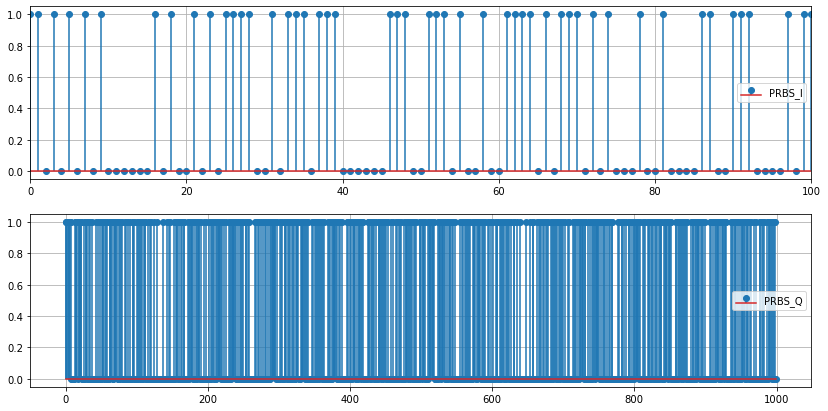

In [16]:
#armarlo como funcion

#secuencia de bits seudo aleatorio
#polinomio de PRBS x^9+x^5+1 
prbs_I=[1,1,0,1,0,1,0,1,0] #0x1AA Semilla
prbs_Q=[1,1,1,1,1,1,1,1,0] #0x1FE semilla
Nsym=1000                  #cantidad de simbolos a transmitir
PRBS_I=[]                  #secuencia generada para le canal I
PRBS_Q=[]                  #secuencia generada para le canal Q
PRBS_I_sim=[]
PRBS_Q_sim=[]
for i in range(Nsym):
    PRBS_I.append(prbs_I[0])
    PRBS_Q.append(prbs_Q[0])
    prbs_I=prbs_I[1:9]+[prbs_I[4]^prbs_I[0]]  #registro de desplazamiento
    prbs_Q=prbs_Q[1:9]+[prbs_Q[4]^prbs_Q[0]]
    if (PRBS_I[i]==1): PRBS_I_sim.append(-1) 
    if (PRBS_Q[i]==1): PRBS_Q_sim.append(-1)
    if (PRBS_I[i]==0): PRBS_I_sim.append(1) 
    if (PRBS_Q[i]==0): PRBS_Q_sim.append(1)  
pl.figure(figsize=[14,7])
pl.subplot(2,1,1)
pl.stem(PRBS_I,label='PRBS_I',use_line_collection=True)
pl.grid(True)
pl.legend()
pl.xlim(0,100)

pl.subplot(2,1,2)
pl.stem(PRBS_Q,label='PRBS_Q',use_line_collection=True)
pl.grid(True)
pl.legend()



# pl.figure(figsize=[14,7])
# pl.subplot(2,1,1)
# pl.stem(PRBS_I_os,label='PRBS_I',use_line_collection=True)
# pl.grid(True)
# pl.legend()
# pl.xlim(0,150)

# pl.subplot(2,1,2)
# pl.stem(PRBS_Q_os,label='PRBS_Q',use_line_collection=True)
# pl.grid(True)
# pl.legend()
# pl.xlim(0,150)

## cauntificacion

[0.0, -0.0625, 0.25, 0.875, -0.125, 0.03125]


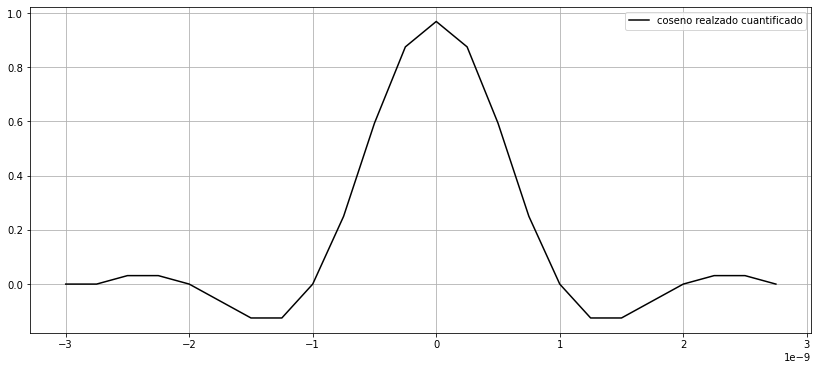

In [11]:
NB=6
NBF=5
Mode='round'
#S(8,7) round
h_PF=arrayFixedInt(NB,NBF,h,signedMode='S',roundMode='round',saturateMode='saturate')
h_fValue = []
for i in range(len(h_PF)):
    h_fValue.append(h_PF[i].fValue)
print(h_fValue[1::4])
pl.figure(figsize=[14,6])
pl.plot(t,h_fValue,'k',label='coseno realzado cuantificado')
pl.grid(True)
pl.legend()

Text(0, 0.5, 'Magnitud [dB]')

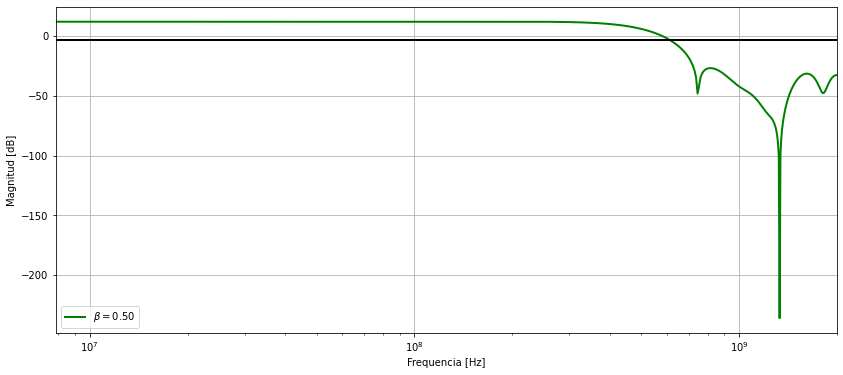

In [12]:
#respuesta en frecuencia
[H_PF,A_PF,F_PF] = resp_freq(h_fValue, Ts, Nfreqs)
pl.figure(figsize=[14,6])
pl.semilogx(F_PF, 20*np.log10(H_PF),'g', linewidth=2.0, label=r'$\beta=%2.2f$'%beta[1])
pl.legend(loc=3)
pl.axhline(y=20*np.log10(0.707),color='k',linewidth=2.0)
pl.grid(True)
pl.xlim(F_PF[1],F_PF[len(F_PF)-1])
pl.xlabel('Frequencia [Hz]')
pl.ylabel('Magnitud [dB]')

(0.0, 200.0)

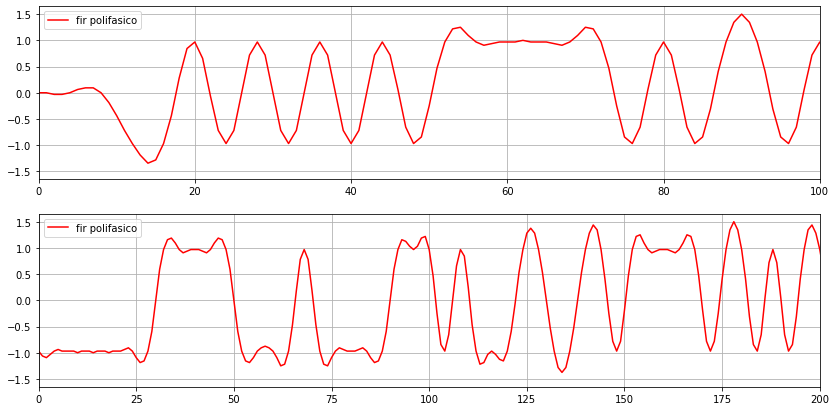

In [15]:
# zeros=np.zeros(int(os*Nbauds))
# y=np.concatenate((PRBS_I_os,zeros))
# y=fir1(y,h_fValue)

zeros1=np.zeros(int(os)-1)
yI=np.concatenate((PRBS_I_sim,[0,0,0]))
yI=fir_polifasico1(yI,h_fValue)

yQ=np.concatenate((PRBS_Q_sim,[0,0,0]))
yQ=fir_polifasico1(yQ,h_fValue)
#print(yI)
pl.figure(figsize=[14,7])
pl.subplot(2,1,1)
pl.plot(yI,'r',label='fir polifasico')
#pl.plot(PRBS_I_os,'o',label='PRBS_I_os')
pl.grid(True)
pl.legend()
pl.xlim(0,100)

pl.subplot(2,1,2)
pl.plot(yQ[12:],'r',label='fir polifasico')
#pl.plot(PRBS_Q_os,'o',label='PRBS_Q_os')
pl.grid(True)
pl.legend()
pl.xlim(0,200)

## deteccion de latencia 

In [177]:
# al ser una prbs de 9 entonces tengo 511 convinaciones posibles 
# antes que se repita la recuencia por lo que contador de 511 ciclos de relog para cambiar a la siguente posicion del shiftreg
offset=0
bit_de_error=0
error_latencia=0
error_min=1
latencia=0
I_rec= yI[offset::int(os)]  #downsampling o diezmado
Q_rec= yQ[offset::int(os)]
I_rec1=[]
Q_rec1=[]
for i in range(len(I_rec)): #obtengo los bits trasmitidos
    if(I_rec[i]<=0):
        I_rec1.append(1)
    else:
        I_rec1.append(0)
    if(Q_rec[i]<=0):
        Q_rec1.append(1)
    else:
        Q_rec1.append(0)
#detector de latencia

while(True):
    for i in range(512):
        if (I_rec1[i+latencia]^PRBS_I[i]):
            error_latencia+=1  
    if (error_latencia>error_min):
        latencia+=1
        error_latencia=0
    else:
        break
print(latencia)
##resolver problema de que se va de rango con fase 2!!!!
# pl.figure(figsize=[14,6])
# pl.plot(PRBS_I,'ro')
# pl.plot(I_rec1,'ko')
# pl.xlim(0,30)
# pl.grid(True)

3


In [163]:
###
I=I_rec1
Q=Q_rec1
I_rec2=I[latencia:]
Q_rec2=Q[latencia:]
for i in range(len(PRBS_I)):
    if(PRBS_I[i]==1 and PRBS_Q[i]==1):                    ##1 cuadrante 00
        if(I_rec2[i]!=1 or Q_rec2[i]!=1):
            bit_de_error+=1
            #print('1 cuadrante')
            #print(I_recivido[i],Q_recivido[i])
            
    if(PRBS_I[i]==1 and PRBS_Q[i]==0):                  #4 cuadrante 11
        if(I_rec2[i]!=1 or Q_rec2[i]!=0):
            bit_de_error+=1
            #print('4 cuadrante')
            #print(I_recivido[i],Q_recivido[i])
            
    if(PRBS_I[i]==0 and PRBS_Q[i]==1):                  #2 cuadrante 01
        if(I_rec2[i]!=0 or Q_rec2[i]!=1):
            bit_de_error+=1
            #print('2 cuadrante')
            #print(I_recivido[i],Q_recivido[i])
            
    if(PRBS_I[i]==0 and PRBS_Q[i]==0):                 #3 cuadrante 10
        if(I_rec2[i]!=0 or Q_rec2[i]!=0):
            bit_de_error+=1
            #print('3 cuadrante')
            #print(I_recivido[i],Q_recivido[i])
            
print('cantidad de simbolos enviados  = {}'.format(len(PRBS_I)))
print('cantidad de simbolos recividos =', len(I_rec1))
print('error:',bit_de_error)
print('BER:',(bit_de_error/len(I_rec1))*100,'%')

cantidad de simbolos enviados  = 1000
cantidad de simbolos recividos = 1003
error: 0
BER: 0.0 %
